# TP 3 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [1]:
import sys
sys.path.append("C:/Users/pablo/VSCodeProjects/Digital-Image-Processing/")
from common.functions import *

In [2]:
from functions import *

In [3]:
%load_ext autoreload
%autoreload 2

***

![ej1](img/consigna_1.png)

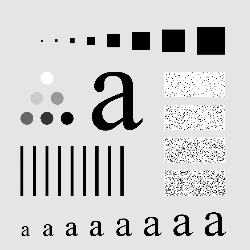

In [35]:
a = cv2.imread('img/a.tif', cv2.IMREAD_GRAYSCALE)
a = cv2.resize(a, (500,500), cv2.INTER_NEAREST)
a_im = Image.fromarray(a)
w, h = a_im.size
displayImage(a_im, w//2, h//2)

Applying kernels

In [42]:
window_sizes = [3,5,9,15,25,35,45,55]
a_comparison = a.copy()
for n in window_sizes:
    kernel = np.ones((n,n),dtype=float)/(n*n)
    filtered_image = cv2.filter2D(src=a, ddepth=-1, kernel=kernel)
    a_comparison = np.concatenate((a_comparison, filtered_image), axis=1)


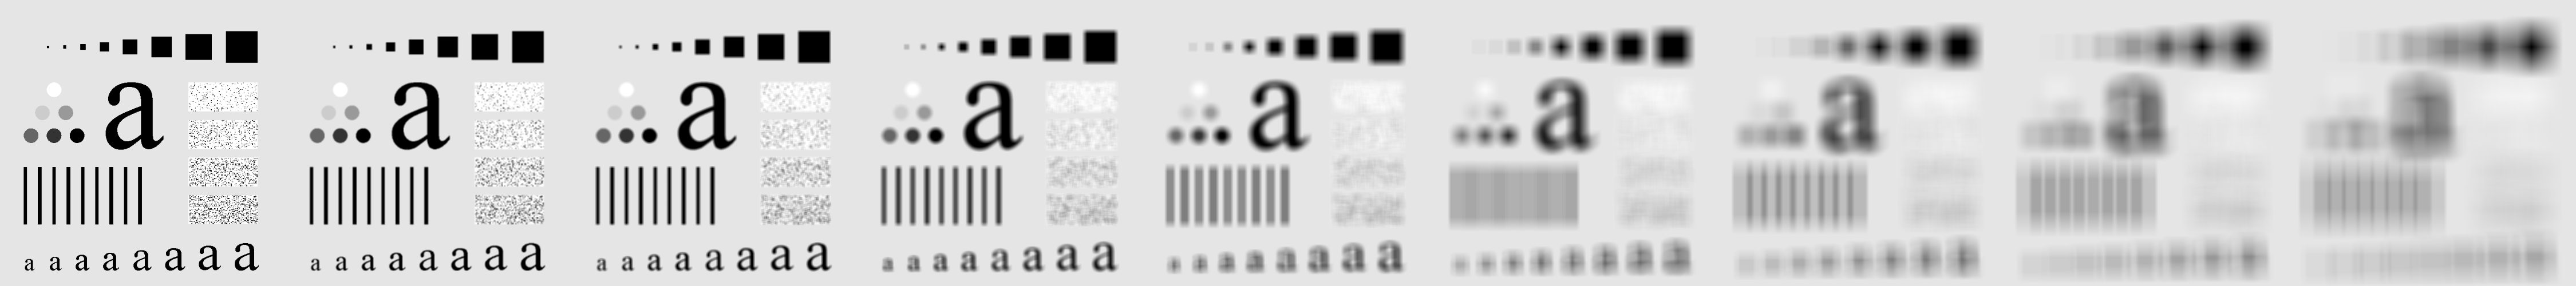

In [43]:
disp_img = Image.fromarray(a_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

***

![ej2](img/consigna_2.png)

***

![ej3](img/consigna_3.png)

***

### 4. Uso del laplaciano para la recuperación del fondo sin perder la información de los bordes

***

### 5. Hi Boost

***

![ej6](img/consigna_6.png)

***

### 7. Dada la imagen lena.tif se pide obtener (usando imadjust): 
* El negativo de la imagen 
* Implementar una transformación tal que convierta los valores entre [0.25 0.5] al rango [0 1]

***

![ej8](img/consigna_8.png)

***

### 9. Realizar la medición de al menos 2 monitores (Laptop-PC) de la corrección gamma usando el fotómetro provisto por la catedra.